In [375]:
import pandas as pd
data=pd.read_csv("Annotations-export.csv")
data.head()

,image,xmin,ymin,xmax,ymax,label
0,2Q__%2520(1).jpg,25.857924,17.226564,110.719403,88.090760,Cat_Face
1,2Q__.jpg,5.396972,6.576271,104.616421,103.466668,Cat_Face
2,9k_%2520(1).jpg,79.079479,5.430552,218.743590,146.337395,Cat_Face
3,2Q__%2520(2).jpg,82.308532,4.487640,195.295220,134.736011,Cat_Face
4,9k_%2520(2).jpg,55.164278,5.977402,185.134605,133.581925,Cat_Face


In [376]:
class BoundingBox(object):
    def __init__(self,xmin,ymin,xmax,ymax):
        self.xmin=xmin
        self.ymin=ymin
        self.xmax=xmax
        self.ymax=ymax
        self.h=ymax-ymin
        self.w=xmax-xmin

In [377]:
X=[]
for i in range(len(data)):
    b=BoundingBox(data["xmin"][i],data["ymin"][i],data["xmax"][i],data["ymax"][i])
    X.append(b)


In [378]:
def iou(box1,box2):
    xi_min=max(box1.xmin,box2.xmin)
    yi_min=max(box1.ymin,box2.ymin)
    xi_max=min(box1.xmax,box2.xmax)
    yi_max=min(box1.ymax,box2.xmax)
    inter_width = xi_max-xi_min
    inter_height = yi_max-yi_min
    inter_area = max(0,inter_width)*max(0,inter_height)
    box1_area = box1.h*box1.w
    box2_area = box2.h*box2.w
    union_area = box1_area+box2_area-inter_area
    iou=inter_area/union_area 
    return iou
    

In [379]:
iou(X[4],X[4])

1.0

In [382]:
def distance(box,centroid):
    d=1-iou(box,centroid)
    return d


In [383]:
def update(clusters):
    new_dict=dict()
    for k,v in clusters.items():
        xmin=[v1.xmin for v1 in v]
        ymin=[v1.ymin for v1 in v]
        xmax=[v1.xmax for v1 in v]
        ymax=[v1.ymax for v1 in v]
        b=BoundingBox(np.mean(xmin),np.mean(ymin),np.mean(xmax),np.mean(ymax))
        new_dict[b]=v
    return  new_dict
        
    
    

In [387]:
def kmeans(X,centroids):
    old_clusters={d:[d] for d in centroids }
    old_liste=[len(x) for x in old_clusters.values()]
    old_liste=np.array(old_liste)
    iteration=0
    while True:
        iteration+=1
        new_clusters={d:[d] for d in centroids }
        dimension=[(round(centroid.h,0),round(centroid.w,0)) for centroid in centroids ]
        
        
        for i in range(len(X)):
            d={centroid:distance(X[i],centroid) for centroid in new_clusters}
            d_sorted=sorted(d.items(), key = lambda kv:(kv[1]))
            new_clusters[d_sorted[0][0]]=new_clusters[d_sorted[0][0]]+[X[i]]
        new_liste=[len(x) for x in new_clusters.values()]
        new_liste=np.array(new_liste)
        
        #print("iteration "+str(iteration)+":")
        #print("old_liste=",old_liste,"new_liste=",new_liste)
        #print("dimension=",dimension)
        if (new_liste==old_liste).all() or iteration>10000:
            break
        else:
            
            
            centroids=list(update(new_clusters).keys())
            old_liste=new_liste.copy()
            
       
        
    return centroids,dimension
            
    

In [399]:
X=np.array(X)
centroids1=X[np.random.choice(len(X),5,replace=False)]
centroids2=X[np.random.choice(len(X),5,replace=False)]

In [400]:
centroids1,dimension1=kmeans(X,centroids1)
centroids2,dimension2=kmeans(X,centroids2)
print("dimension 1=",dimension1)
print("dimension 2=",dimension2)


dimension 1= [(112.0, 122.0), (40.0, 41.0), (77.0, 81.0), (70.0, 76.0), (46.0, 55.0)]
dimension 2= [(116.0, 127.0), (32.0, 32.0), (69.0, 76.0), (48.0, 51.0), (80.0, 84.0)]


In [401]:
def avg_IOU(X,centroids):
    n=len(X)
    sum = 0.
    for i in range(n):
        liste=[iou(c,X[i]) for c in centroids]
        #note IOU() will return array which contains IoU for each centroid and X[i] // slightly ineffective, but I am too lazy
        sum+= max(liste) 
    return sum/n

In [402]:
avg1=avg_IOU(X,centroids1)
avg2=avg_IOU(X,centroids2)
print("avg1=",avg1)
print("avg2=",avg2)

avg1= 0.5429130536316586
avg2= 0.557437307051035


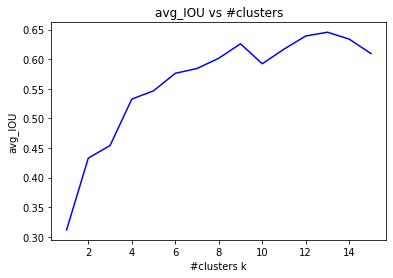

In [403]:
import matplotlib.pyplot as plt
K=[i for i in range(1,16)]
X=np.array(X)
avg_iou=[]
box_number=len(X)
for k in K:
    centroids=X[np.random.choice(
            box_number, k, replace=False)]
    result=kmeans(X,centroids)
    new_centroids=result[0]
    avg_iou.append(avg_IOU(X,new_centroids))

plt.plot(K,avg_iou,color="blue")
plt.xlabel("#clusters k")
plt.ylabel("avg_IOU")
plt.title("avg_IOU vs #clusters")
plt.show()

In [405]:
def save_anchors(centroids,filename):
    with open(filename,"w") as f:
        for c in centroids:
            f.write(str(c.h))
            f.write("\t")
            f.write(str(c.w))
            f.write("\n")
    print("Succefully saved in file")
        

In [407]:

filename="anchors.txt"
save_anchors(new_centroids,filename)

Succefully saved in file
